# Astro-ph Knowledge Graph Dataset Statistics

This notebook analyzes the astro-ph knowledge graph dataset including:
- Concept distribution and coverage
- Citation network statistics
- Temporal trends
- Concept co-occurrence patterns


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ast
from pathlib import Path

# Create figures directory
Path('figures').mkdir(exist_ok=True)

# Reset matplotlib to default settings first
plt.rcdefaults()

# Try to use scienceplots style, but fall back gracefully if not available
try:
    import scienceplots
    plt.style.use(['science', 'no-latex'])
    print("Using scienceplots style")
except ImportError:
    print("scienceplots not available, using default matplotlib style")
    # Set up a clean, publication-ready style manually
    plt.style.use('default')

# Set publication-quality parameters for crisp, professional plots
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['figure.dpi'] = 150  # Higher DPI for sharper display
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.1
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linewidth'] = 0.8
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Set even higher DPI for ultra-crisp figures
plt.rcParams['figure.dpi'] = 200  # Increased from 150
plt.rcParams['savefig.dpi'] = 600  # Increased from 300


# Use a professional color palette with better contrast
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

print("Loading data...")


Using scienceplots style
Loading data...


## 1. Load Dataset

We begin by loading all components of the knowledge graph. This dataset represents about 400,000 astrophysics papers from arXiv, each tagged with machine-learned concepts and connected through citation relationships.


In [2]:
# Load concept vocabulary
concepts = pd.read_csv('concepts_vocabulary.csv.gz')
print(f"Concepts: {len(concepts):,}")

# Load paper-concept mappings
papers_concepts = pd.read_csv('papers_concepts_mapping.csv.gz', dtype={'arxiv_id': str})
print(f"Paper-concept associations: {len(papers_concepts):,}")

# Load paper index
papers = pd.read_csv('papers_index_mapping.csv.gz', dtype={'arxiv_id': str})
print(f"Total papers: {len(papers):,}")

# Load paper years array (indexed by paper_idx)
papers_years = np.load('papers_years.npy')
print(f"Papers with year data: {len(papers_years):,}")
print(f"Year range: {papers_years.min()}-{papers_years.max()}")

# Load citation graph
citations = pd.read_json('citations_indexed.jsonl.gz', lines=True)
print(f"Citation graph entries: {len(citations):,}")


Concepts: 9,999
Paper-concept associations: 3,827,232
Total papers: 408,590
Papers with year data: 408,590
Year range: 1992-2025
Citation graph entries: 408,590


## 2. Concept Distribution Analysis

Each paper in the dataset has been tagged with multiple concepts by GPT-4o and o1-mini. Understanding how many concepts are assigned per paper helps us gauge the granularity of the knowledge representation. A higher number suggests fine-grained topical coverage, while consistency in the distribution indicates systematic tagging.


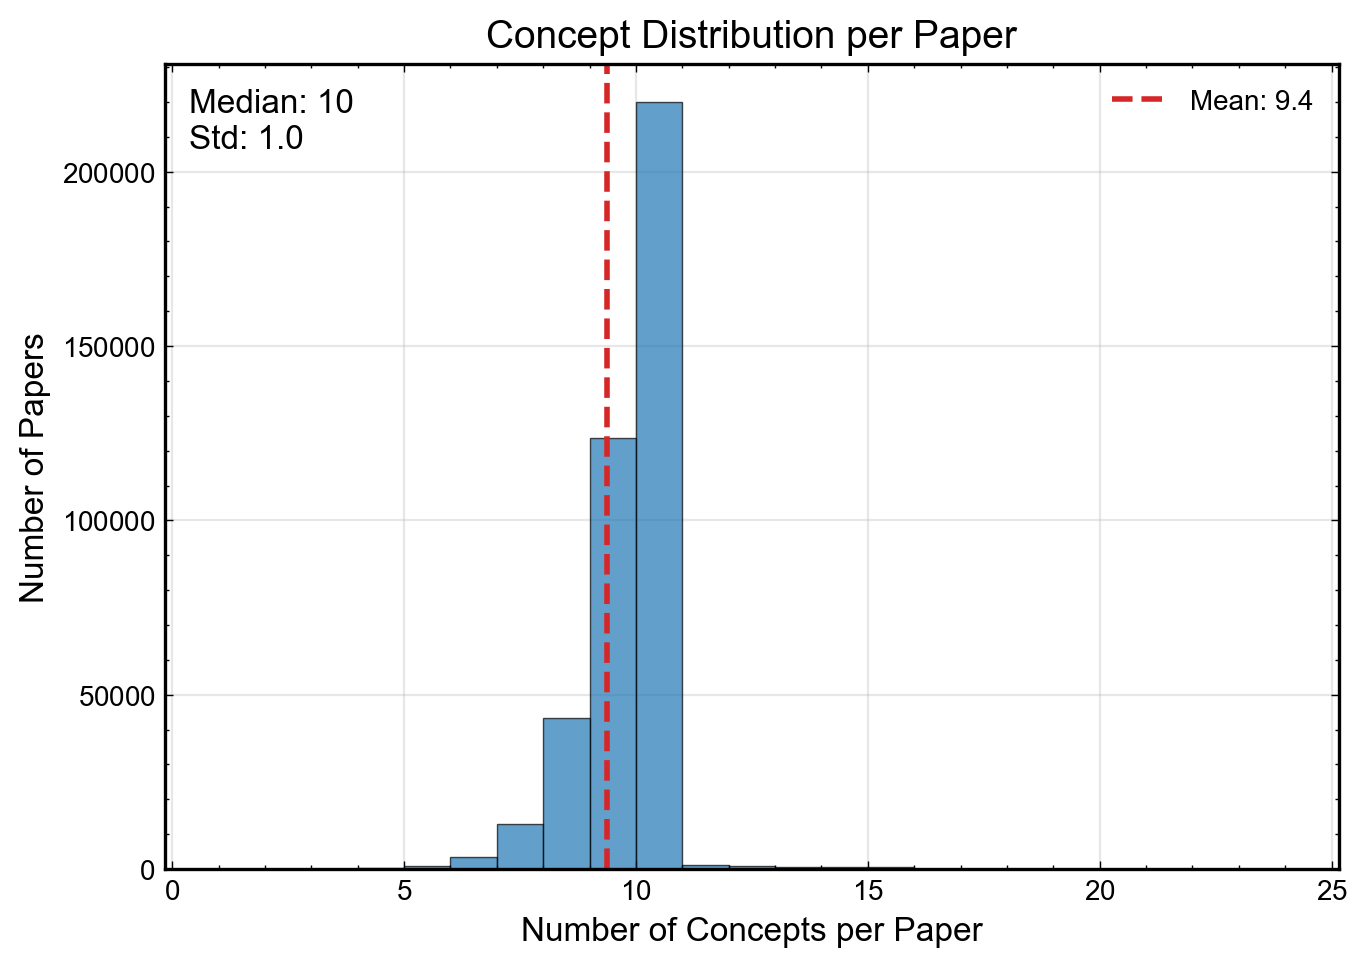


Average concepts per paper: 9.37


In [3]:
# Number of concepts per paper
concepts_per_paper = papers_concepts.groupby('arxiv_id').size()

fig, ax = plt.subplots(figsize=(7, 5))

# Histogram
n, bins, patches = ax.hist(concepts_per_paper, bins=range(1, 25), 
                            edgecolor='black', alpha=0.7, color=colors[0], linewidth=0.5)

# Add mean line
mean_val = concepts_per_paper.mean()
ax.axvline(mean_val, color=colors[3], linestyle='--', linewidth=2,
           label=f'Mean: {mean_val:.1f}')

ax.set_xlabel('Number of Concepts per Paper')
ax.set_ylabel('Number of Papers')
ax.set_title('Concept Distribution per Paper')
ax.legend(loc='upper right')

# Add summary text
textstr = f'Median: {concepts_per_paper.median():.0f}\nStd: {concepts_per_paper.std():.1f}'
ax.text(0.02, 0.97, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='left')

plt.tight_layout()
plt.savefig('figures/concepts_per_paper_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAverage concepts per paper: {concepts_per_paper.mean():.2f}")


## 3. Concept Popularity: What Topics Dominate?

Some concepts appear much more frequently than others, reflecting the research trends in astrophysics. The most common concepts represent foundational topics that many papers touch upon, while rare concepts capture niche areas of study.


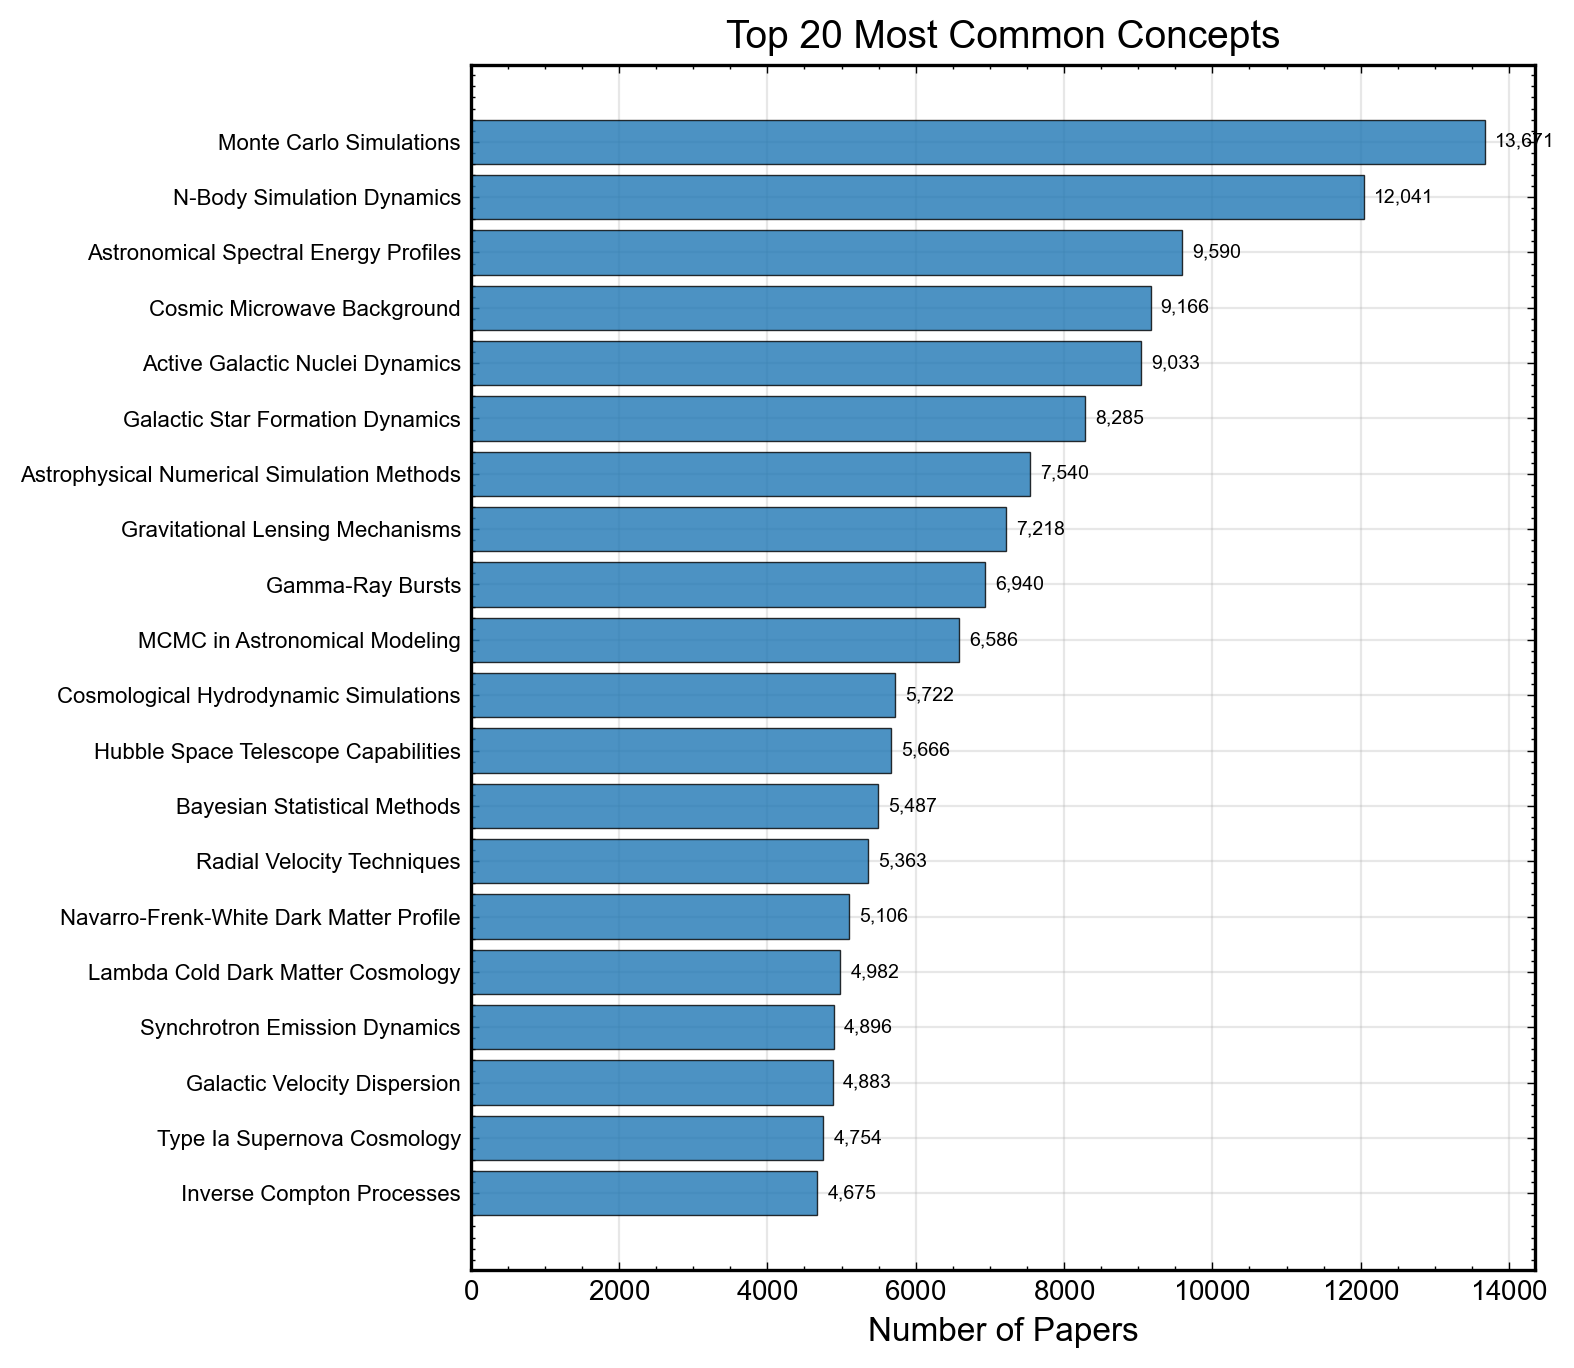


Top 10 Concepts:
 1. Monte Carlo Simulations                                      13,671 papers
 2. N-Body Simulation Dynamics                                   12,041 papers
 3. Astronomical Spectral Energy Profiles                         9,590 papers
 4. Cosmic Microwave Background                                   9,166 papers
 5. Active Galactic Nuclei Dynamics                               9,033 papers
 6. Galactic Star Formation Dynamics                              8,285 papers
 7. Astrophysical Numerical Simulation Methods                    7,540 papers
 8. Gravitational Lensing Mechanisms                              7,218 papers
 9. Gamma-Ray Bursts                                              6,940 papers
10. MCMC in Astronomical Modeling                                 6,586 papers


In [4]:
# Frequency of each concept
concept_freq = papers_concepts.groupby('label').size().sort_values(ascending=False)

# Get concept names for top concepts
top_20_concepts = concept_freq.head(20)
top_concepts_with_names = []
for label, count in top_20_concepts.items():
    concept_name = concepts[concepts['label'] == label]['concept'].values[0]
    top_concepts_with_names.append((concept_name, count))

# Plot top 20 concepts
fig, ax = plt.subplots(figsize=(8, 7))
names = [name[:50] + '...' if len(name) > 50 else name for name, _ in top_concepts_with_names]
counts = [count for _, count in top_concepts_with_names]

# Use consistent color
bars = ax.barh(range(len(names)), counts, color=colors[0], edgecolor='black', linewidth=0.5, alpha=0.8)
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names, fontsize=8)
ax.set_xlabel('Number of Papers')
ax.set_title('Top 20 Most Common Concepts')
ax.invert_yaxis()

# Add value labels
for i, (bar, count) in enumerate(zip(bars, counts)):
    ax.text(count + max(counts)*0.01, i, f'{count:,}', va='center', fontsize=7)

plt.tight_layout()
plt.savefig('figures/top_20_concepts.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 10 Concepts:")
for i, (name, count) in enumerate(top_concepts_with_names[:10], 1):
    print(f"{i:2d}. {name[:60]:60s} {count:6,} papers")


## 4. Balanced Distribution of Concept Frequencies
 
Unlike traditional keywords which exhibit extreme clustering at the ends (very common or very rare), our concepts show a more balanced distribution across the frequency range (note: plotted on log scale). This reflects the systematic clustering approach: concepts are designed to have relatively uniform coverage across papers, avoiding both over-general and over-specific categories. This makes the concept system more suitable for quantitative analysis and machine learning applications.


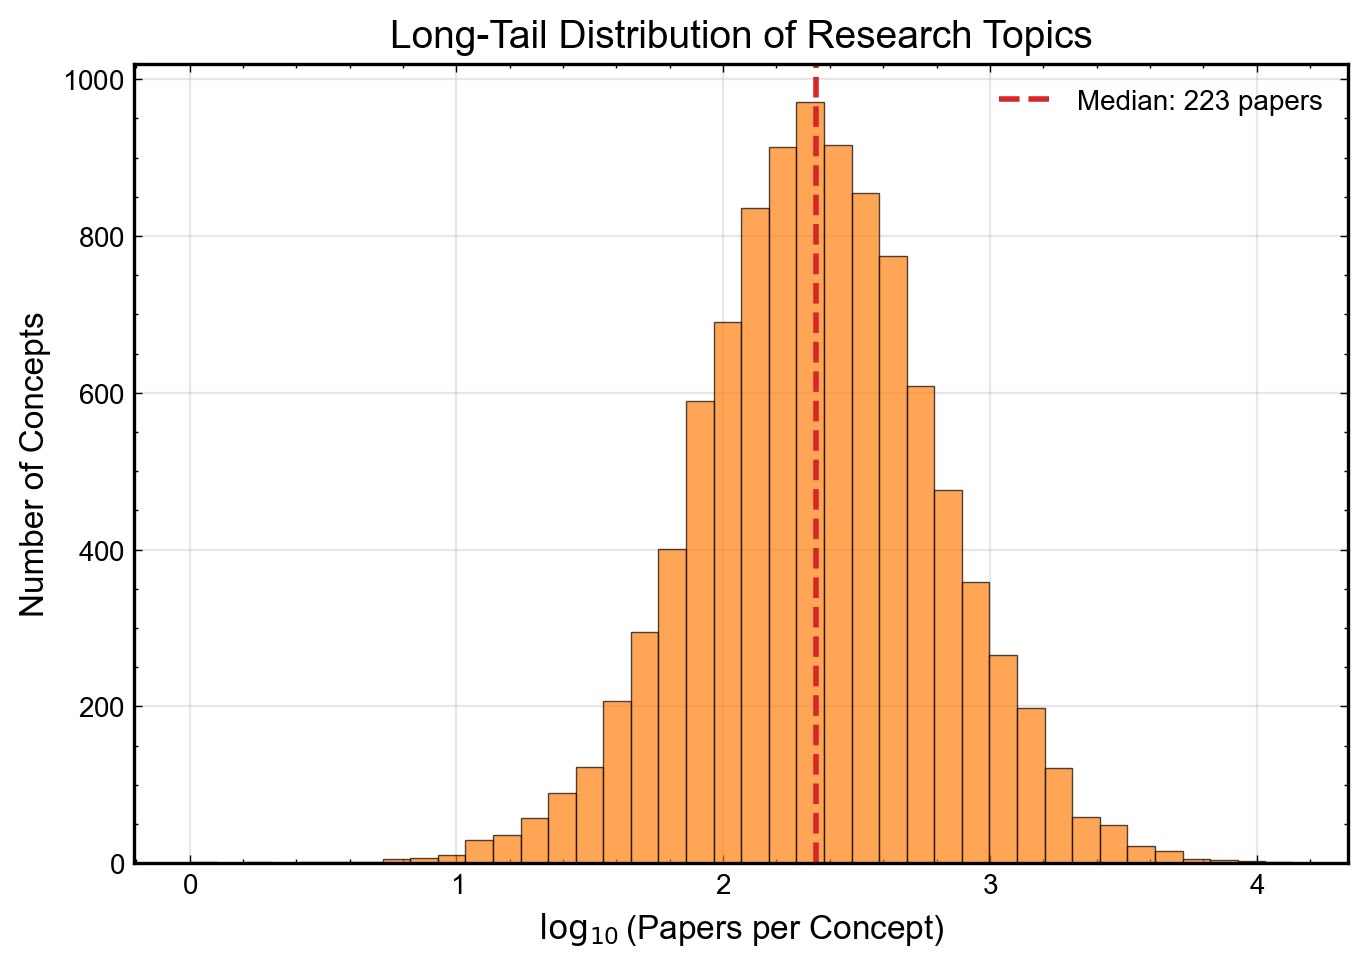


Concept frequency statistics:
Mean papers per concept: 382.8
Median papers per concept: 223
Min papers per concept: 1
Max papers per concept: 13,671


In [5]:
# Distribution of concept frequencies (log scale)
fig, ax = plt.subplots(figsize=(7, 5))

# Log scale histogram
log_freq = np.log10(concept_freq)
n, bins, patches = ax.hist(log_freq, bins=40, edgecolor='black', 
                            alpha=0.7, color=colors[1], linewidth=0.5)

ax.set_xlabel(r'$\log_{10}$(Papers per Concept)')
ax.set_ylabel('Number of Concepts')
ax.set_title('Long-Tail Distribution of Research Topics')

# Add annotation
median_log = np.log10(concept_freq.median())
ax.axvline(median_log, color=colors[3], linestyle='--', linewidth=2,
           label=f'Median: {concept_freq.median():.0f} papers')
ax.legend(loc='best')

plt.tight_layout()
plt.savefig('figures/concept_frequency_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nConcept frequency statistics:")
print(f"Mean papers per concept: {concept_freq.mean():.1f}")
print(f"Median papers per concept: {concept_freq.median():.0f}")
print(f"Min papers per concept: {concept_freq.min()}")
print(f"Max papers per concept: {concept_freq.max():,}")


## 5. Research Category Distribution

The concepts have been clustered into high-level research categories. This categorization helps understand which major sub-fields of astrophysics are represented in the knowledge graph.


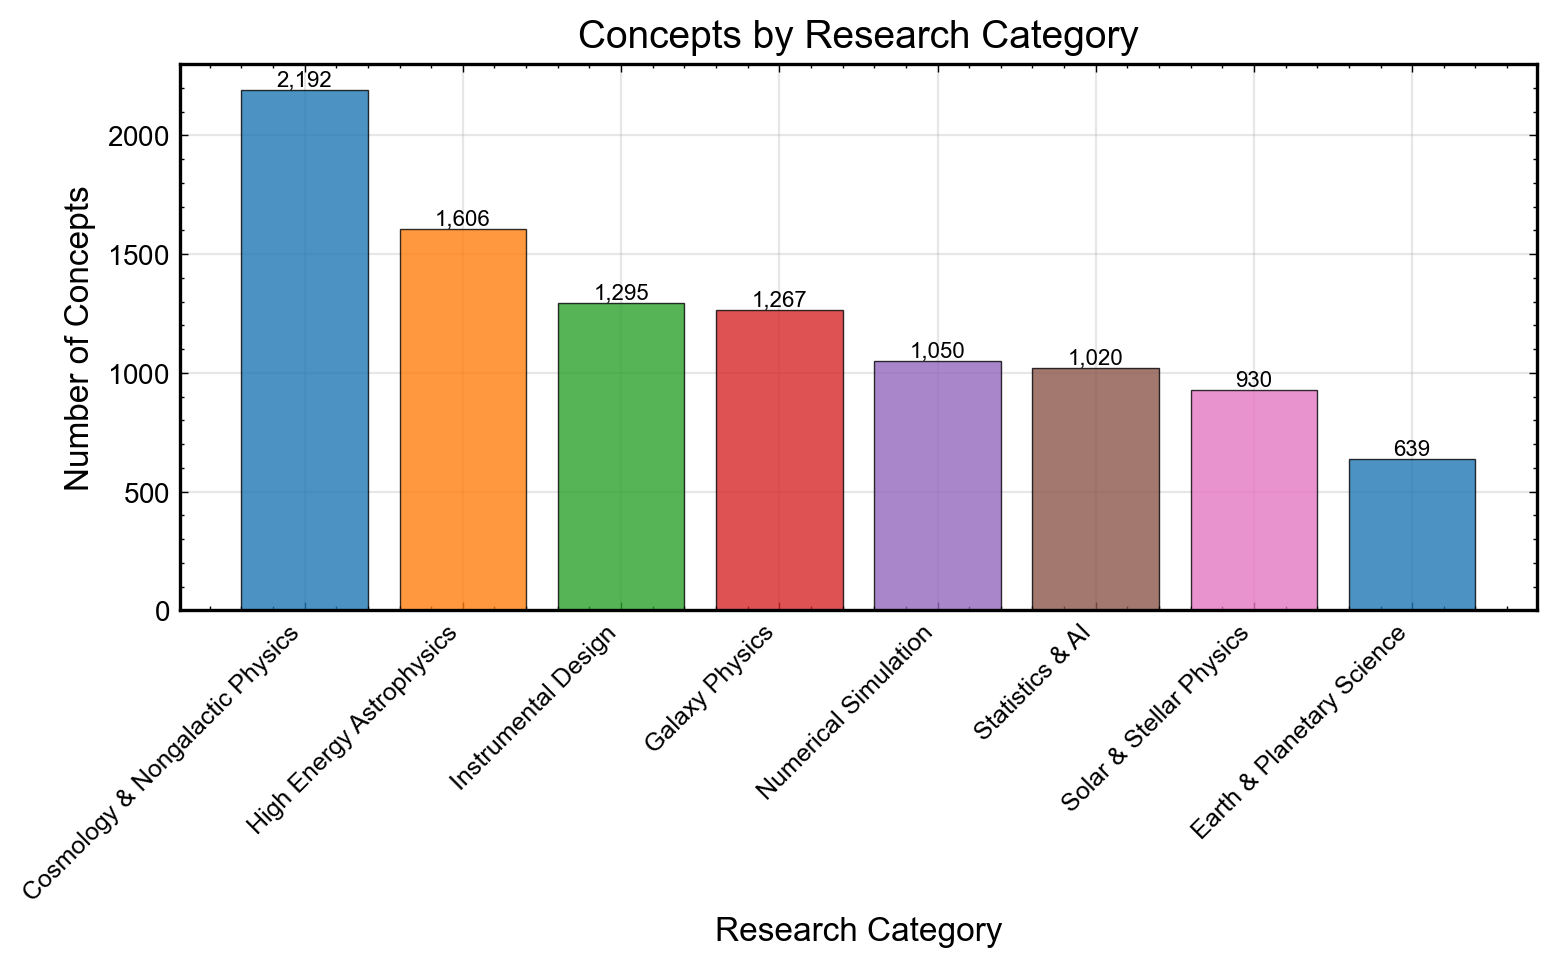


Concepts by category:
Cosmology & Nongalactic Physics          2,192 ( 21.9%)
High Energy Astrophysics                 1,606 ( 16.1%)
Instrumental Design                      1,295 ( 13.0%)
Galaxy Physics                           1,267 ( 12.7%)
Numerical Simulation                     1,050 ( 10.5%)
Statistics & AI                          1,020 ( 10.2%)
Solar & Stellar Physics                    930 (  9.3%)
Earth & Planetary Science                  639 (  6.4%)


In [6]:
# Category distribution
category_counts = concepts['class'].value_counts()

fig, ax = plt.subplots(figsize=(8, 5))

# Use consistent colors
bars = ax.bar(range(len(category_counts)), category_counts.values, 
              color=colors[:len(category_counts)], edgecolor='black', linewidth=0.5, alpha=0.8)

ax.set_xticks(range(len(category_counts)))
ax.set_xticklabels(category_counts.index, rotation=45, ha='right', fontsize=9)
ax.set_xlabel('Research Category')
ax.set_ylabel('Number of Concepts')
ax.set_title('Concepts by Research Category')

# Add value labels
for bar, count in zip(bars, category_counts.values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count):,}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('figures/concepts_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConcepts by category:")
for cat, count in category_counts.items():
    print(f"{cat:40s} {count:5,} ({count/len(concepts)*100:5.1f}%)")


## 6. Citation Network: How Papers Connect

Citations form the backbone of scientific knowledge transfer. By analyzing reference and citation patterns, we can understand how research builds upon prior work and which papers have the greatest influence.


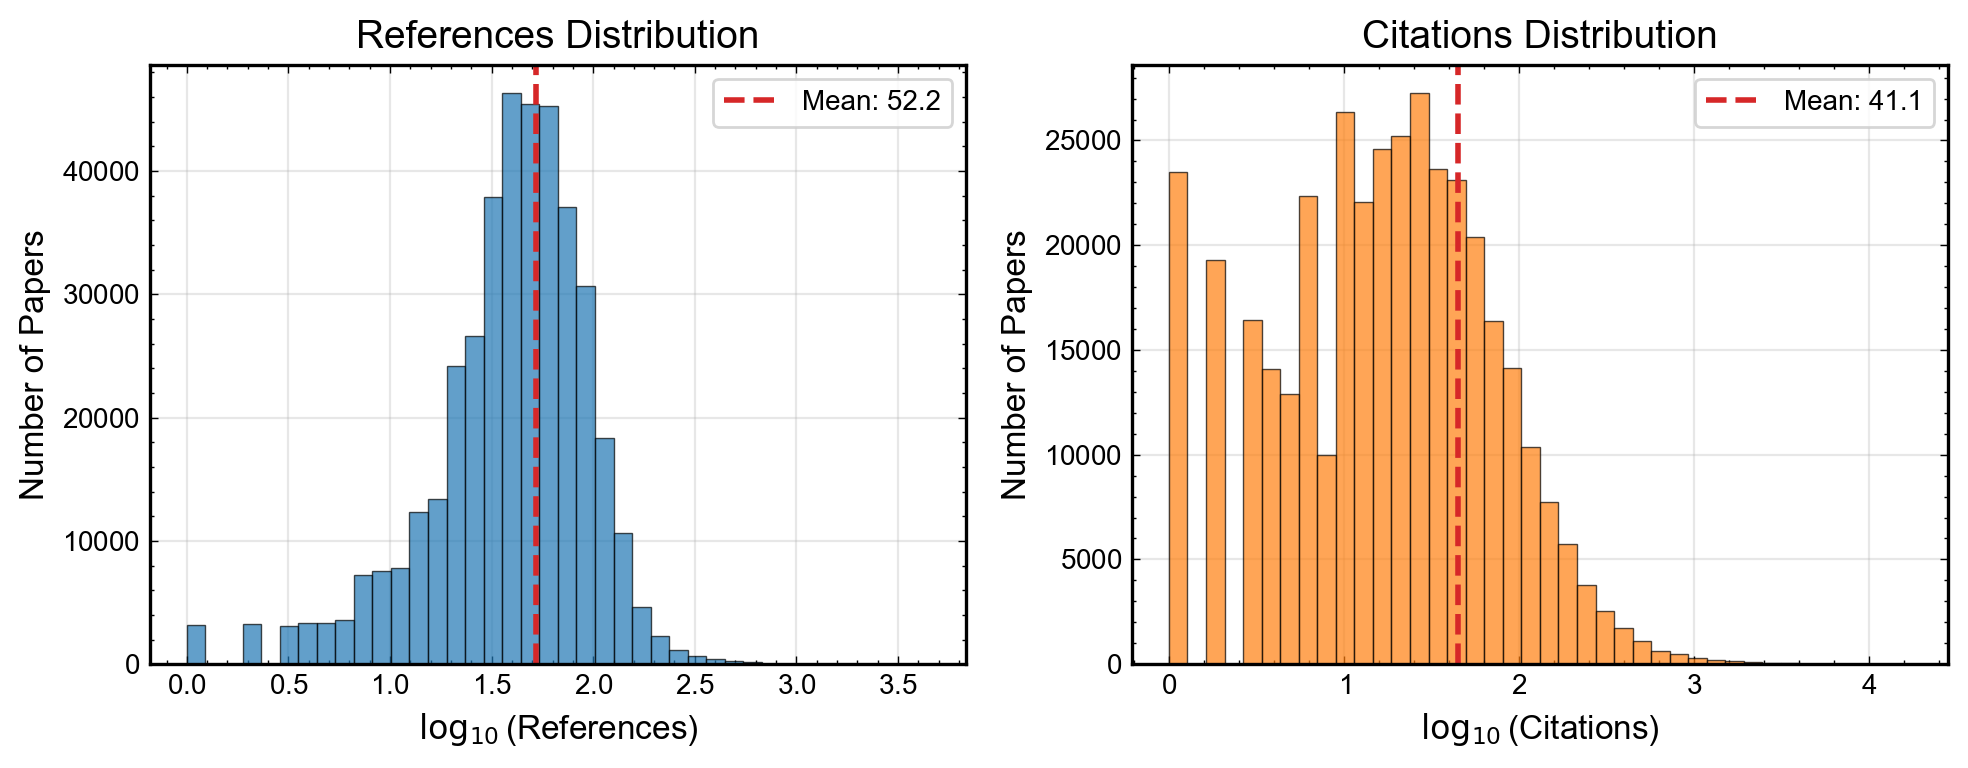


Citation Network Statistics:
Total papers: 408,590

References:
  Mean: 52.20
  Median: 43
  Max: 4,490
  Papers with no references: 8,391

Citations:
  Mean: 41.07
  Median: 15
  Max: 17,321
  Papers with no citations: 32,036


In [7]:
# Citation statistics are already computed in the data
# The columns num_references and num_citations contain the counts
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Log scale references (only non-zero)
refs_nonzero = citations[citations['num_references'] > 0]['num_references']
axes[0].hist(np.log10(refs_nonzero), bins=40, edgecolor='black', 
             alpha=0.7, color=colors[0], linewidth=0.5)
axes[0].set_xlabel(r'$\log_{10}$(References)')
axes[0].set_ylabel('Number of Papers')
axes[0].set_title('References Distribution')
mean_log_refs = np.log10(citations['num_references'].mean())
axes[0].axvline(mean_log_refs, color=colors[3], linestyle='--', linewidth=2,
                label=f'Mean: {citations["num_references"].mean():.1f}')
axes[0].legend(frameon=True, loc='best')

# Log scale citations (only non-zero)
cites_nonzero = citations[citations['num_citations'] > 0]['num_citations']
axes[1].hist(np.log10(cites_nonzero), bins=40, edgecolor='black', 
             alpha=0.7, color=colors[1], linewidth=0.5)
axes[1].set_xlabel(r'$\log_{10}$(Citations)')
axes[1].set_ylabel('Number of Papers')
axes[1].set_title('Citations Distribution')
mean_log_cites = np.log10(citations[citations['num_citations'] > 0]['num_citations'].mean())
axes[1].axvline(mean_log_cites, color=colors[3], linestyle='--', linewidth=2,
                label=f'Mean: {citations["num_citations"].mean():.1f}')
axes[1].legend(frameon=True, loc='best')

plt.tight_layout()
plt.savefig('figures/citation_network_statistics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCitation Network Statistics:")
print(f"Total papers: {len(citations):,}")
print(f"\nReferences:")
print(f"  Mean: {citations['num_references'].mean():.2f}")
print(f"  Median: {citations['num_references'].median():.0f}")
print(f"  Max: {citations['num_references'].max():,}")
print(f"  Papers with no references: {(citations['num_references'] == 0).sum():,}")
print(f"\nCitations:")
print(f"  Mean: {citations['num_citations'].mean():.2f}")
print(f"  Median: {citations['num_citations'].median():.0f}")
print(f"  Max: {citations['num_citations'].max():,}")
print(f"  Papers with no citations: {(citations['num_citations'] == 0).sum():,}")


Top 20 Most Cited Papers:
astro-ph-9805201     17,321 citations
astro-ph-9812133     16,615 citations
1807.06209           16,582 citations
astro-ph-9710327     13,761 citations
1502.01589           13,065 citations
1307.6212            12,478 citations
1602.03837           12,205 citations
1202.3665            11,404 citations
astro-ph-0302209     10,541 citations
astro-ph-9611107      9,607 citations
astro-ph-0006396      9,544 citations
astro-ph-0309134      9,476 citations
1801.02634            8,997 citations
1710.05832            8,776 citations
astro-ph-0304382      8,342 citations
1303.5076             8,271 citations
1001.4538             8,233 citations
0909.0948             8,146 citations
astro-ph-9508025      7,990 citations
1804.09365            7,879 citations


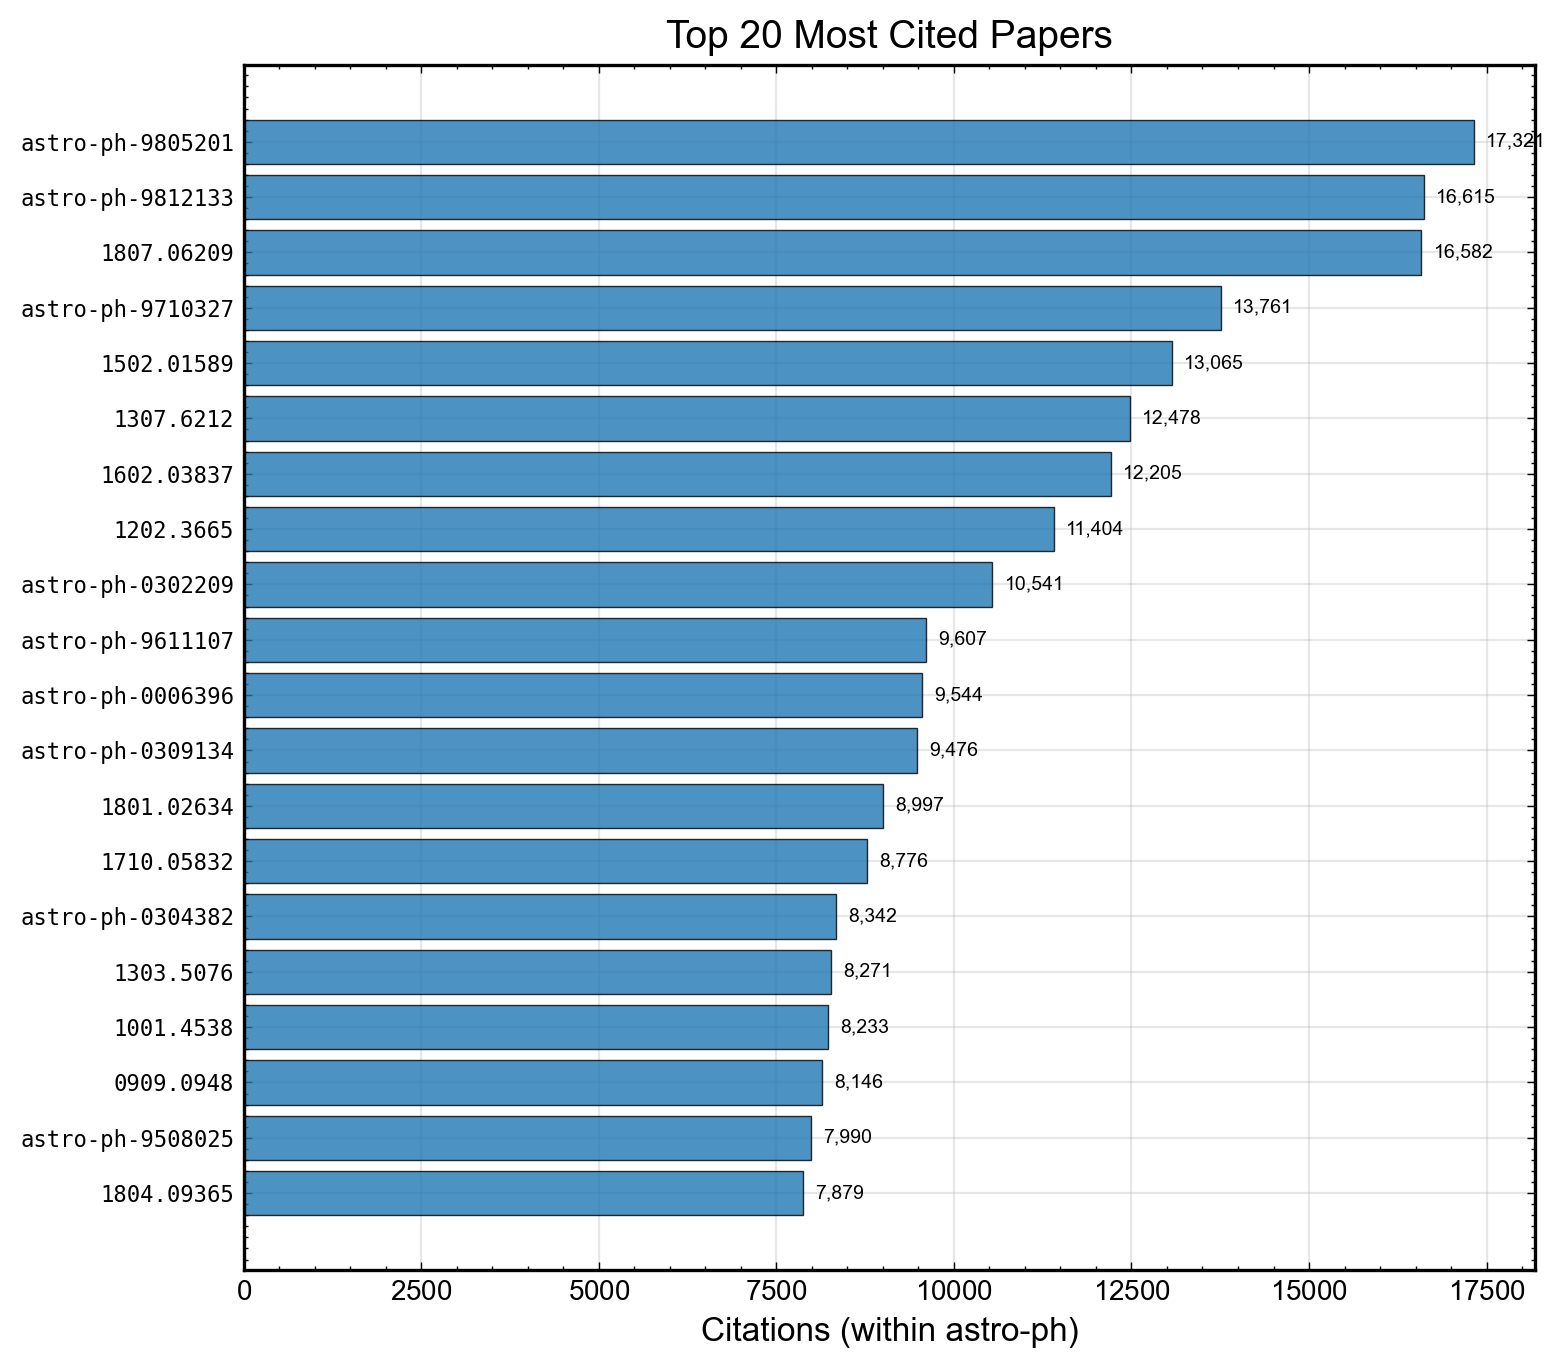

In [8]:
# Find most cited papers
top_cited = citations.nlargest(20, 'num_citations')[['paper_idx', 'num_citations']]

# Get arXiv IDs
top_cited_with_ids = top_cited.merge(papers, on='paper_idx')

print("Top 20 Most Cited Papers:")
print("="*80)
for i, row in top_cited_with_ids.iterrows():
    print(f"{row['arxiv_id']:20s} {row['num_citations']:6,} citations")

# Plot
fig, ax = plt.subplots(figsize=(8, 7))

bars = ax.barh(range(len(top_cited_with_ids)), top_cited_with_ids['num_citations'],
               color=colors[0], edgecolor='black', linewidth=0.5, alpha=0.8)

ax.set_yticks(range(len(top_cited_with_ids)))
ax.set_yticklabels(top_cited_with_ids['arxiv_id'], fontsize=8, family='monospace')
ax.set_xlabel('Citations (within astro-ph)')
ax.set_title('Top 20 Most Cited Papers')
ax.invert_yaxis()

# Add value labels
max_count = top_cited_with_ids['num_citations'].max()
for i, (bar, count) in enumerate(zip(bars, top_cited_with_ids['num_citations'])):
    ax.text(count + max_count*0.01, i, f'{count:,}', 
            va='center', fontsize=7)

plt.tight_layout()
plt.savefig('figures/most_cited_papers.png', dpi=300, bbox_inches='tight')
plt.show()


## 7. Temporal Evolution of Research

Analyzing the dataset's temporal coverage helps us understand the historical scope and growth of astrophysics research on arXiv.


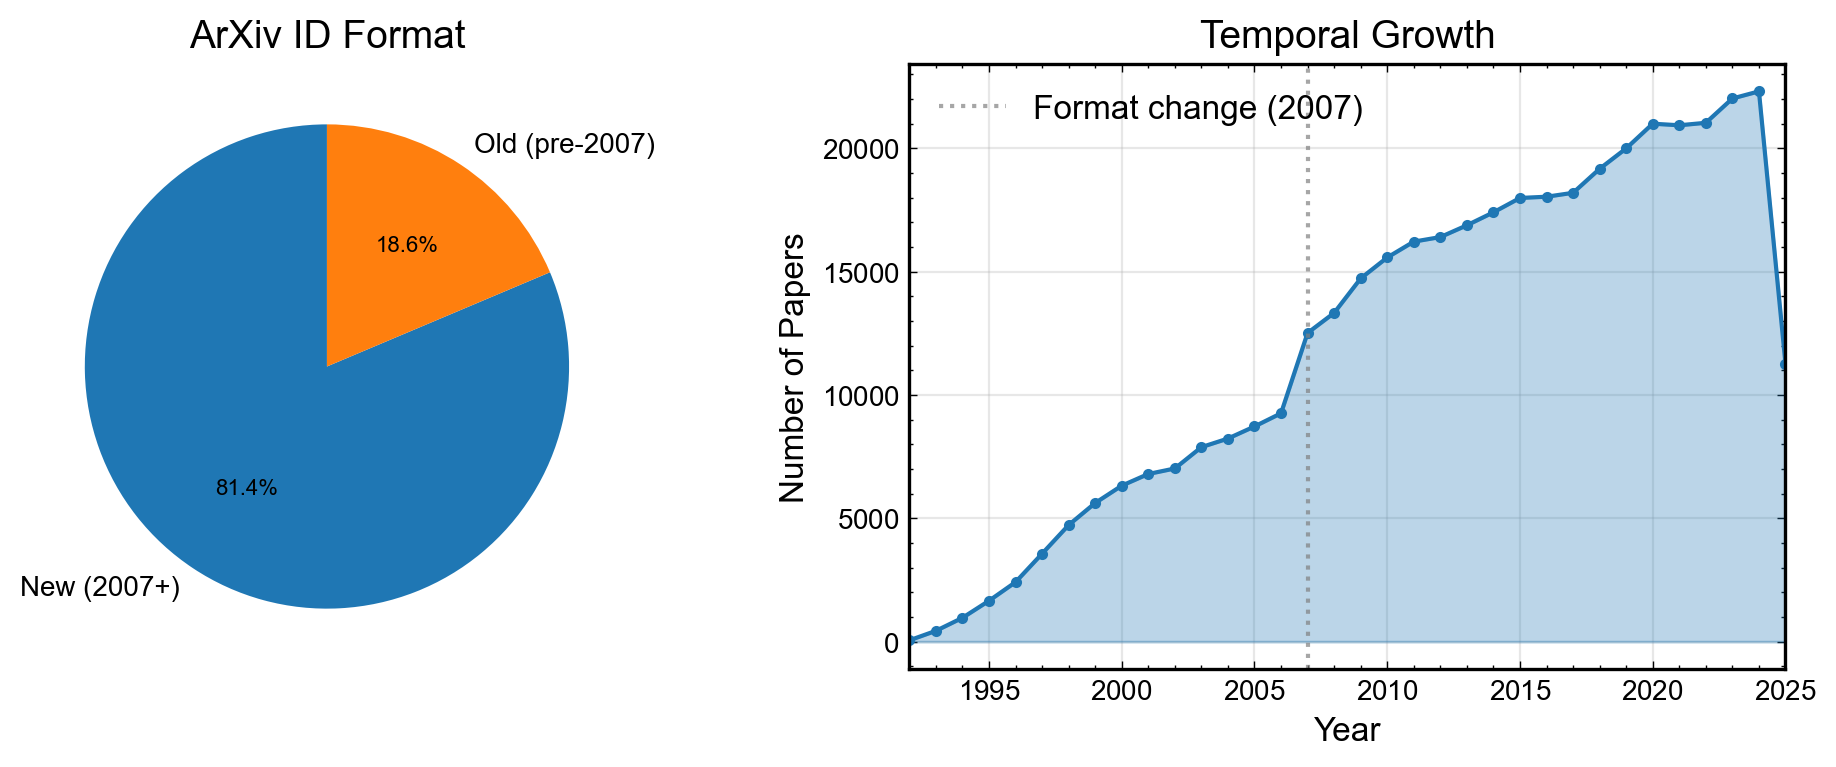


ArXiv ID Formats:
New (2007+): 332,437 (81.4%)
Old (pre-2007): 76,153 (18.6%)

Year range: 1992 - 2025


In [10]:
# Analyze arXiv ID formats
papers['format'] = papers['arxiv_id'].apply(lambda x: 'Old (pre-2007)' if '-' in x else 'New (2007+)')
format_counts = papers['format'].value_counts()

# Extract years from arXiv IDs
def extract_year(arxiv_id):
    try:
        if '-' in arxiv_id:
            # Old format: astro-ph-0001001 -> ['astro', 'ph', '0001001']
            parts = arxiv_id.split('-')
            if len(parts) >= 3:
                yymm = parts[2]  # Format: astro-ph-YYMMnnn
                yy = int(yymm[:2])  # Extract YY
                return 2000 + yy if yy < 90 else 1900 + yy
        else:
            # New format: 0704.0001
            yy = int(arxiv_id[:2])
            return 2000 + yy if yy < 90 else 1900 + yy
    except:
        return None

papers['year'] = papers['arxiv_id'].apply(extract_year)
papers_with_year = papers[papers['year'].notna()]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Format pie chart
wedges, texts, autotexts = axes[0].pie(format_counts.values, labels=format_counts.index, 
                                         autopct='%1.1f%%', startangle=90,
                                         colors=[colors[0], colors[1]])
for autotext in autotexts:
    autotext.set_fontsize(8)
axes[0].set_title('ArXiv ID Format')

# Papers by year
year_counts = papers_with_year['year'].value_counts().sort_index()
axes[1].fill_between(year_counts.index, year_counts.values, alpha=0.3, color=colors[0])
axes[1].plot(year_counts.index, year_counts.values, marker='o', linewidth=1.5, 
             markersize=3, color=colors[0])
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Number of Papers')
axes[1].set_title('Temporal Growth')
axes[1].set_xlim(year_counts.index.min(), year_counts.index.max())

# Add vertical line for format change
axes[1].axvline(2007, color='gray', linestyle=':', linewidth=1.5, 
                label='Format change (2007)', alpha=0.7)
axes[1].legend(loc='upper left', fontsize=12)

plt.tight_layout()
plt.savefig('figures/arxiv_format_and_temporal.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nArXiv ID Formats:")
for fmt, count in format_counts.items():
    print(f"{fmt}: {count:,} ({count/len(papers)*100:.1f}%)")

print(f"\nYear range: {int(papers_with_year['year'].min())} - {int(papers_with_year['year'].max())}")


## 8. Temporal Evolution: Concept Emergence

Understanding when concepts emerge helps trace the evolution of astrophysics research. We define "emergence" as when a concept first appears in at least 5 papers (reducing noise from one-off mentions).

The analysis reveals three distinct phases:
1. **1990s boom**: Foundational concepts when arXiv began
2. **2007 peak**: Secondary expansion (likely astro-ph as secondary category)
3. **2015-2025**: Modern ML/AI concepts dominating recent additions


In [11]:
# Generate temporal evolution data
print("Generating concept emergence timeline...")

# Merge concept assignments with publication years
# Add paper_idx to papers_concepts, then use it to get years from the numpy array
concept_years = papers_concepts.merge(papers[['arxiv_id', 'paper_idx']], on='arxiv_id')
concept_years['year'] = papers_years[concept_years['paper_idx'].values]
concept_years = concept_years.merge(concepts[['label', 'concept']], on='label')

# Calculate first appearance year for each concept
first_year = concept_years.groupby('concept')['year'].min().reset_index()
first_year.columns = ['concept', 'first_year']

# Calculate year when each concept crossed 5 papers threshold
concept_year_counts = concept_years.groupby(['concept', 'year']).size().reset_index(name='count')
concept_year_counts = concept_year_counts.sort_values(['concept', 'year'])
concept_year_counts['cumulative'] = concept_year_counts.groupby('concept')['count'].cumsum()
year_crossed_5 = concept_year_counts[concept_year_counts['cumulative'] >= 5].groupby('concept')['year'].first().reset_index()
year_crossed_5.columns = ['concept', 'year_crossed_5']

# Total papers per concept
total_papers_per_concept = concept_years.groupby('concept').size().reset_index(name='total_papers')

# Merge all to create timeline
timeline_df = first_year.merge(year_crossed_5, on='concept', how='left')
timeline_df = timeline_df.merge(total_papers_per_concept, on='concept')

print(f"✓ Timeline generated")
print(f"\nTotal concepts tracked: {len(timeline_df):,}")
print(f"Concepts with ≥5 papers: {timeline_df['year_crossed_5'].notna().sum():,}")
print(f"\nEra breakdown:")
print(f"  1990s: {((timeline_df['year_crossed_5'] >= 1990) & (timeline_df['year_crossed_5'] < 2000)).sum():,} concepts")
print(f"  2000s: {((timeline_df['year_crossed_5'] >= 2000) & (timeline_df['year_crossed_5'] < 2010)).sum():,} concepts")
print(f"  2010s: {((timeline_df['year_crossed_5'] >= 2010) & (timeline_df['year_crossed_5'] < 2020)).sum():,} concepts")
print(f"  2020s: {((timeline_df['year_crossed_5'] >= 2020)).sum():,} concepts")


Generating concept emergence timeline...
✓ Timeline generated

Total concepts tracked: 9,761
Concepts with ≥5 papers: 9,756

Era breakdown:
  1990s: 4,980 concepts
  2000s: 4,053 concepts
  2010s: 683 concepts
  2020s: 40 concepts


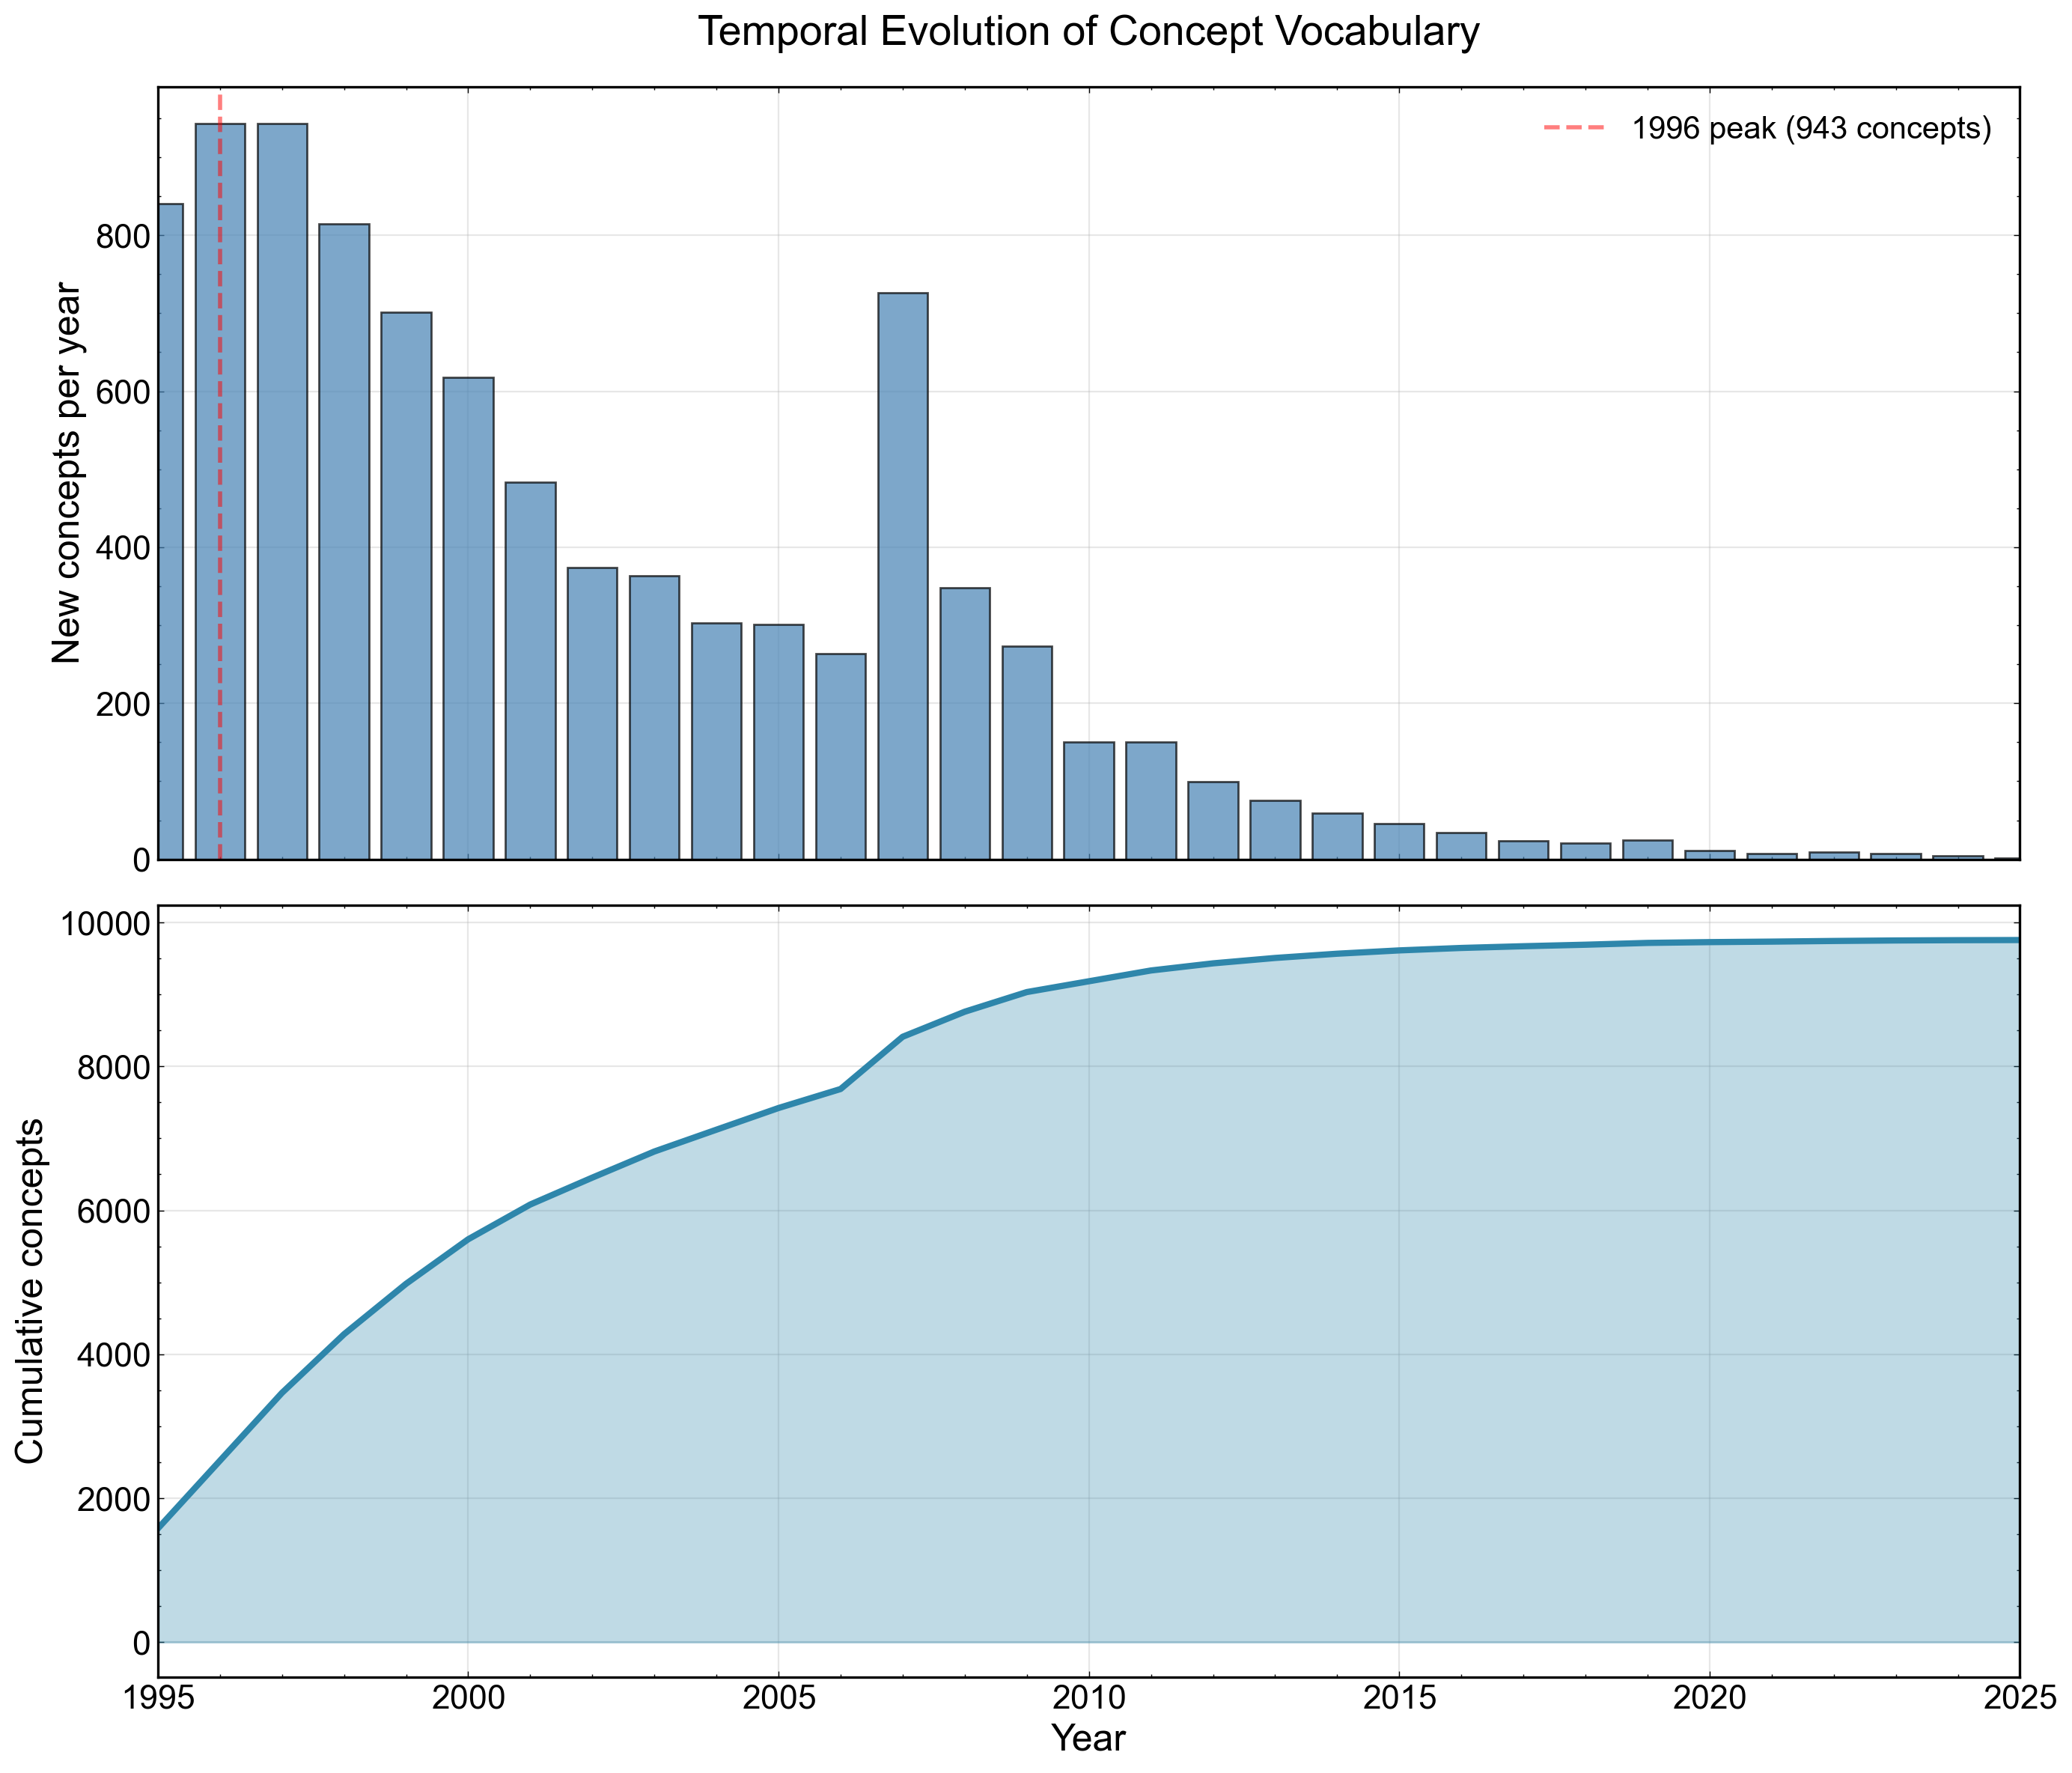


Peak year: 1996 with 943 new concepts
Total concepts as of 2025: 9756


In [12]:
# Generate concept emergence timeline
# Count concepts emerging each year
concepts_by_year = timeline_df[timeline_df['year_crossed_5'].notna()].groupby('year_crossed_5').size()
concepts_by_year = concepts_by_year.sort_index()

# Cumulative growth
cumulative = concepts_by_year.cumsum()

# Create two-panel figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Top panel: New concepts per year
years = concepts_by_year.index
ax1.bar(years, concepts_by_year.values, color='steelblue', edgecolor='black', alpha=0.7)
# Highlight 2007 peak
peak_year = concepts_by_year.idxmax()
peak_count = concepts_by_year.max()
ax1.axvline(x=peak_year, color='red', linestyle='--', linewidth=2, alpha=0.5, 
            label=f'{int(peak_year)} peak ({int(peak_count)} concepts)')
ax1.set_ylabel('New concepts per year', fontsize=18)
ax1.set_title('Temporal Evolution of Concept Vocabulary', fontsize=20, pad=20)
ax1.tick_params(labelsize=16)
ax1.grid(alpha=0.3, axis='y')
ax1.legend(fontsize=15, loc='upper right')

# Bottom panel: Cumulative growth
ax2.plot(cumulative.index, cumulative.values, linewidth=3, color='#2E86AB')
ax2.fill_between(cumulative.index, 0, cumulative.values, alpha=0.3, color='#2E86AB')
ax2.set_xlabel('Year', fontsize=18)
ax2.set_ylabel('Cumulative concepts', fontsize=18)
ax2.tick_params(labelsize=16)
ax2.grid(alpha=0.3)

# Set x-axis range
ax2.set_xlim(1995, 2025)

plt.tight_layout()
plt.savefig('figures/concept_emergence_timeline.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPeak year: {int(peak_year)} with {int(peak_count)} new concepts")
print(f"Total concepts as of 2025: {int(cumulative.iloc[-1])}")


### Recent Concepts (2015-2025)

The concepts emerging in the last decade reflect current research frontiers. The dominance of machine learning and AI-related concepts demonstrates the rapid adoption of modern computational techniques in astrophysics.


In [14]:
# Get concepts that emerged post-2015
recent_concepts = timeline_df[(timeline_df['year_crossed_5'] >= 2015) & (timeline_df['year_crossed_5'].notna())]
recent_concepts_sorted = recent_concepts.sort_values('total_papers', ascending=False)

print(f"Concepts emerging 2015-2025: {len(recent_concepts)}\n")
print("Top 30 by total papers:")
for idx, row in recent_concepts_sorted.head(30).iterrows():
    print(f"  {row['concept']}: {row['total_papers']} papers (emerged: {int(row['year_crossed_5'])})")


Concepts emerging 2015-2025: 190

Top 30 by total papers:
  Astronomical CNN Applications: 1676 papers (emerged: 2015)
  Deep Learning in Astronomy: 604 papers (emerged: 2015)
  Astronomical Data Augmentation: 403 papers (emerged: 2015)
  Residual Neural Networks: 402 papers (emerged: 2017)
  U-Net Variants in Astronomy: 373 papers (emerged: 2018)
  GW170817 Multimessenger Merger: 324 papers (emerged: 2017)
  Probabilistic Transformation Flows: 288 papers (emerged: 2019)
  Autoencoder Architectures: 281 papers (emerged: 2015)
  Astronomical Transfer Learning: 273 papers (emerged: 2015)
  S8 Clustering Discrepancy: 240 papers (emerged: 2017)
  Gaia-Sausage-Enceladus Merger: 215 papers (emerged: 2018)
  Neural Inference Methods: 202 papers (emerged: 2019)
  Gravitational Wave Mergers: 202 papers (emerged: 2016)
  Exoplanet Radiative Transfer Codes: 198 papers (emerged: 2016)
  Adversarial Neural Architectures: 196 papers (emerged: 2017)
  Transformer Architectures in Astronomy: 185 paper

## 9. Comparison: ADS Keywords vs. Extracted Concepts

Traditional ADS keywords are manually assigned by authors, while our concepts are systematically extracted using GPT-4o and o1-mini. This comparison demonstrates the differences in distribution, frequency patterns, and provides insight into the advantages of our approach.


In [15]:
# Load ADS keywords data
ads_keywords = pd.read_csv('ads_keywords_curated.csv.gz', dtype={'arxiv_id': str})

print(f"ADS Keywords: {len(ads_keywords):,} keyword assignments")
print(f"  Unique keywords: {ads_keywords['keyword'].nunique():,}")
print(f"  Unique papers: {ads_keywords['arxiv_id'].nunique():,}")
print(f"\nComparison:")
print(f"  Extracted Concepts: {len(papers_concepts):,} concept assignments")
print(f"  Unique concepts: {papers_concepts['label'].nunique():,}")
print(f"  Unique papers: {papers_concepts['arxiv_id'].nunique():,}")


ADS Keywords: 1,269,903 keyword assignments
  Unique keywords: 6,909
  Unique papers: 298,657

Comparison:
  Extracted Concepts: 3,827,232 concept assignments
  Unique concepts: 9,999
  Unique papers: 408,590


### Distribution Comparison

ADS keywords are manually assigned by authors, often resulting in under-specification (few keywords) or over-specification (too many). Our system provides consistent concept coverage across all papers. 

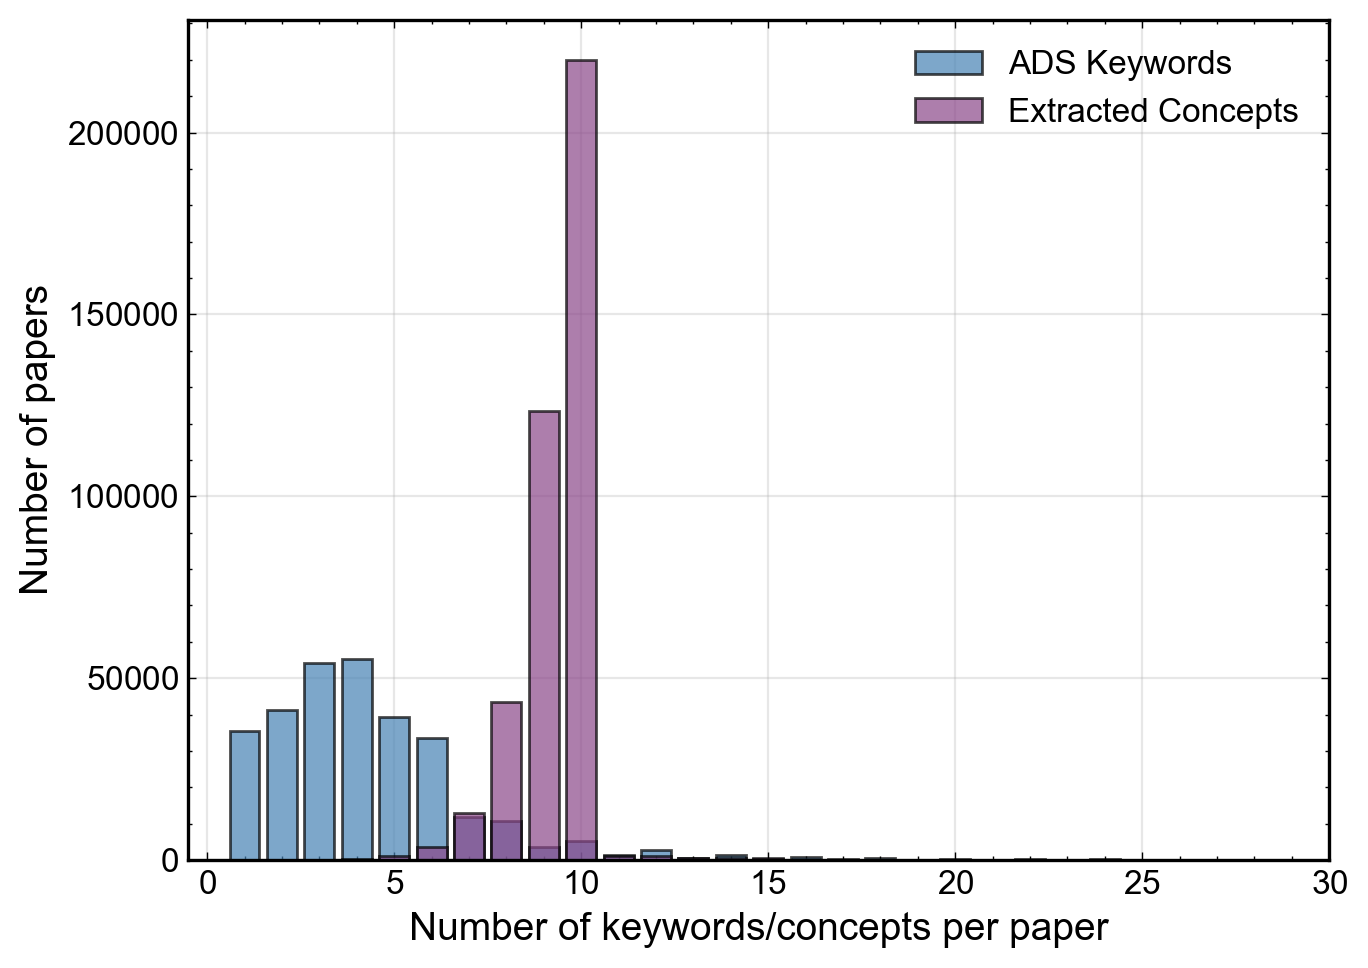


ADS Keywords - Median per paper: 4.0
Extracted Concepts - Median per paper: 10.0


In [16]:
# Keywords/concepts per paper distribution
ads_per_paper = ads_keywords.groupby('arxiv_id').size()
ting_per_paper = papers_concepts.groupby('arxiv_id').size()

# Create overlapping bar chart
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

bins = np.arange(0, max(ads_per_paper.max(), ting_per_paper.max()) + 2)
ads_hist, _ = np.histogram(ads_per_paper, bins=bins)
ting_hist, _ = np.histogram(ting_per_paper, bins=bins)

x = bins[:-1]
width = 0.8

ax.bar(x, ads_hist, width=width, alpha=0.7, color='steelblue', edgecolor='black', label='ADS Keywords')
ax.bar(x, ting_hist, width=width, alpha=0.7, color='#8B4789', edgecolor='black', label='Extracted Concepts')
ax.set_xlabel('Number of keywords/concepts per paper', fontsize=14)
ax.set_ylabel('Number of papers', fontsize=14)
ax.set_xlim(-0.5, 30)
ax.legend(fontsize=12)
ax.tick_params(labelsize=12)
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/keywords_per_paper_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nADS Keywords - Median per paper: {ads_per_paper.median():.1f}")
print(f"Extracted Concepts - Median per paper: {ting_per_paper.median():.1f}")


### Frequency Distribution

The frequency distribution reveals how often each keyword/concept appears across the dataset. ADS keywords tend to cluster at extremes (very rare or very common), while AI concepts show more balanced usage patterns that avoid being overly broad or overly specific.


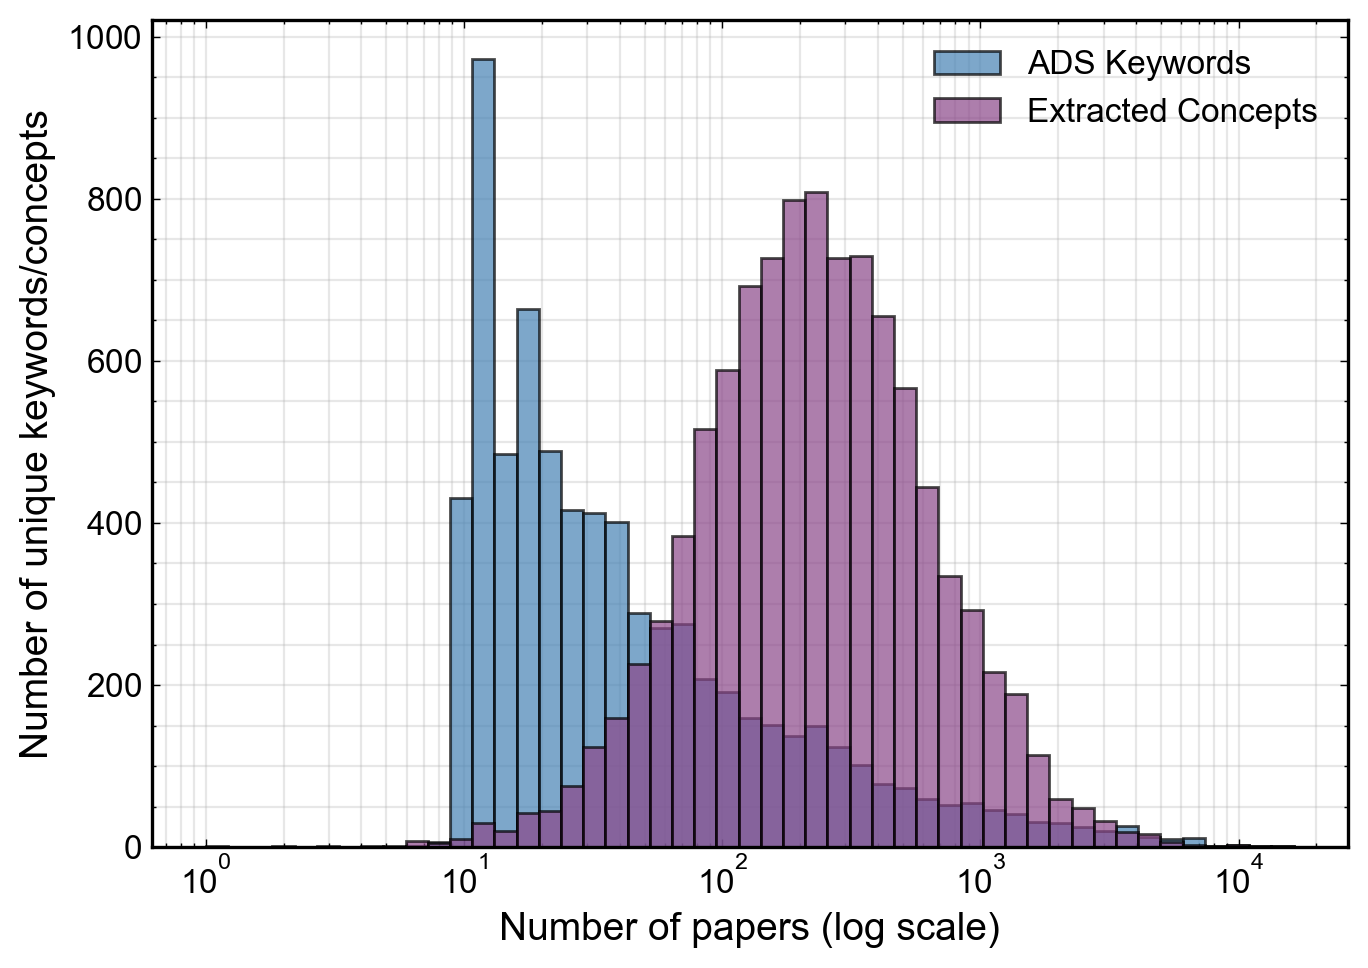


ADS Keywords - Median frequency: 28 papers
Extracted Concepts - Median frequency: 223 papers


In [17]:
# Frequency of each keyword/concept
ads_freq = ads_keywords.groupby('keyword').size()
ting_freq = papers_concepts.groupby('label').size()

# Create overlapping histogram on log scale
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

bins = np.logspace(0, np.log10(max(ads_freq.max(), ting_freq.max())), 50)

ax.hist(ads_freq, bins=bins, alpha=0.7, color='steelblue', edgecolor='black', label='ADS Keywords')
ax.hist(ting_freq, bins=bins, alpha=0.7, color='#8B4789', edgecolor='black', label='Extracted Concepts')
ax.set_xlabel('Number of papers (log scale)', fontsize=14)
ax.set_ylabel('Number of unique keywords/concepts', fontsize=14)
ax.set_xscale('log')
ax.legend(fontsize=12, loc='upper right')
ax.tick_params(labelsize=12)
ax.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('figures/keyword_frequency_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nADS Keywords - Median frequency: {ads_freq.median():.0f} papers")
print(f"Extracted Concepts - Median frequency: {ting_freq.median():.0f} papers")


## 10. Summary Statistics

This comprehensive summary brings together all key findings from the dataset analysis, providing a quick reference for the complete astro-ph knowledge graph.


In [18]:
print("="*80)
print("DATASET SUMMARY STATISTICS")
print("="*80)

print(f"\n📊 Overall:")
print(f"  Total papers: {len(papers):,}")
print(f"  Total unique concepts: {len(concepts):,}")
print(f"  Total paper-concept associations: {len(papers_concepts):,}")

print(f"\n📝 Concepts:")
print(f"  Average concepts per paper: {concepts_per_paper.mean():.1f}")
print(f"  Median concepts per paper: {concepts_per_paper.median():.0f}")
print(f"  Average papers per concept: {concept_freq.mean():.1f}")
print(f"  Most common concept: {concepts[concepts['label'] == concept_freq.index[0]]['concept'].values[0]}")
print(f"    → Used in {concept_freq.values[0]:,} papers")

print(f"\n🔑 ADS Keywords (for comparison):")
print(f"  Total keyword assignments: {len(ads_keywords):,}")
print(f"  Papers with keywords: {ads_keywords['arxiv_id'].nunique():,}")
print(f"  Unique keywords: {ads_keywords['keyword'].nunique():,}")
print(f"  Median keywords per paper: {ads_per_paper.median():.1f}")

print(f"\n🔗 Citation Network:")
print(f"  Papers with citation data: {len(citations):,}")
print(f"  Average references per paper: {citations['num_references'].mean():.1f}")
print(f"  Average citations per paper: {citations['num_citations'].mean():.1f}")
print(f"  Most cited paper: {top_cited_with_ids.iloc[0]['arxiv_id']}")
print(f"    → {top_cited_with_ids.iloc[0]['num_citations']:,} citations")

print(f"\n📅 Temporal Coverage:")
print(f"  Year range: {int(papers_with_year['year'].min())} - {int(papers_with_year['year'].max())}")
print(f"  Old format IDs (pre-2007): {format_counts.get('Old (pre-2007)', 0):,}")
print(f"  New format IDs (2007+): {format_counts.get('New (2007+)', 0):,}")
print(f"  Concept vocabulary established: {int(cumulative.iloc[-1])} concepts with ≥5 papers")

print("\n" + "="*80)
print("All figures saved to figures/ directory")
print("="*80)


DATASET SUMMARY STATISTICS

📊 Overall:
  Total papers: 408,590
  Total unique concepts: 9,999
  Total paper-concept associations: 3,827,232

📝 Concepts:
  Average concepts per paper: 9.4
  Median concepts per paper: 10
  Average papers per concept: 382.8
  Most common concept: Monte Carlo Simulations
    → Used in 13,671 papers

🔑 ADS Keywords (for comparison):
  Total keyword assignments: 1,269,903
  Papers with keywords: 298,657
  Unique keywords: 6,909
  Median keywords per paper: 4.0

🔗 Citation Network:
  Papers with citation data: 408,590
  Average references per paper: 52.2
  Average citations per paper: 41.1
  Most cited paper: astro-ph-9805201
    → 17,321 citations

📅 Temporal Coverage:
  Year range: 1992 - 2025
  Old format IDs (pre-2007): 76,153
  New format IDs (2007+): 332,437
  Concept vocabulary established: 9756 concepts with ≥5 papers

All figures saved to figures/ directory
